# Understanding the Fourier Transform by example
How to implement the Fast Fourier Transform algorithm in Python from scratch. <br />
@author: Simon J. Buehrer <br />
@date: 2021-02-04 <br /><br />
**Links:**
<ul>
<li> https://towardsdatascience.com/fast-fourier-transform-937926e591cb </li>
<li> https://www.ritchievink.com/blog/2017/04/23/understanding-the-fourier-transform-by-example/ </li>
<li> https://towardsdatascience.com/analyzing-seasonality-with-fourier-transforms-using-python-scipy-bb46945a23d3 </li>
</ul> 

In [51]:
# Additional functions for analysing and manipulating data
import pandas as pd 
# Date Functions
import datetime as dt 

import yfinance as yf #pip install yfinance /or pip3 /or conda
import numpy as np
import statsmodels.api as sm 

# This function adds plotting functions for calender dates
from pandas.plotting import register_matplotlib_converters
# Important package for visualization - we use this to plot the market data
import matplotlib.pyplot as plt 
# Formatting dates
import matplotlib.dates as mdates


## get data

In [52]:
#get current day and download hist. data (today-1000)
today = dt.datetime.today().strftime('%Y-%m-%d')
hist = (dt.datetime.today()-dt.timedelta(2000)).strftime('%Y-%m-%d')

stockname='ABB'
print(today,hist)
stockdata_df = yf.download(stockname, start=hist, end=today)
print(stockdata_df.head(5))

2021-02-04 2015-08-15
[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2015-08-14  19.980000  20.059999  19.910000  20.020000  16.505568  1182100
2015-08-17  19.959999  20.070000  19.900000  20.070000  16.546785   818800
2015-08-18  19.920000  19.969999  19.840000  19.879999  16.390141   885500
2015-08-19  19.620001  19.830000  19.580000  19.700001  16.241743  2374900
2015-08-20  19.650000  19.660000  19.290001  19.290001  15.903716  2135300


## viusalize data

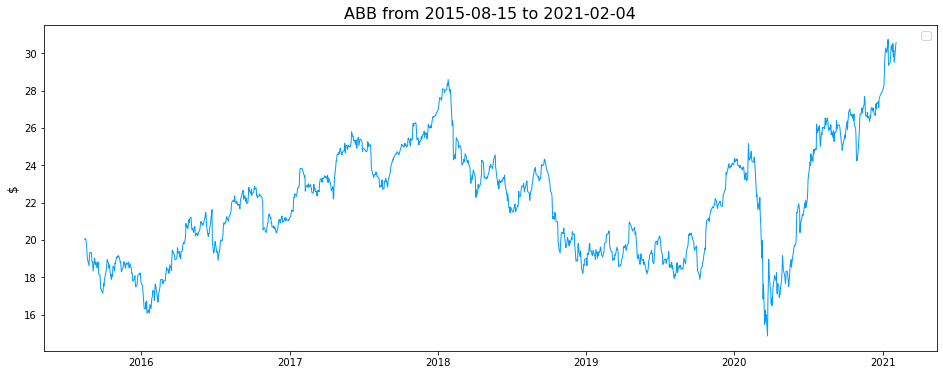

In [53]:
# Plotting the data
register_matplotlib_converters()
years = mdates.YearLocator() 
fig, ax1 = plt.subplots(figsize=(16, 6))
ax1.xaxis.set_major_locator(years)
x = stockdata_df.index
y = stockdata_df['Close']
#ax1.fill_between(x, 0, y, color='#b9e1fa')
ax1.legend([stockname], fontsize=12)
plt.title(stockname + ' from '+ hist + ' to ' + today, fontsize=16)
plt.plot(y, color='#039dfc', label=stockname, linewidth=1.0)
plt.ylabel('$', fontsize=12)
plt.show()

## Calculating the difference

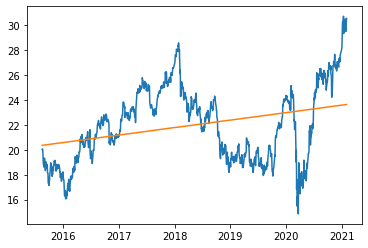

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     149.8
Date:                Thu, 04 Feb 2021   Prob (F-statistic):           9.03e-33
Time:                        14:42:21   Log-Likelihood:                -3409.2
No. Observations:                1378   AIC:                             6822.
Df Residuals:                    1376   BIC:                             6833.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.3624      0.155    131.559      0.0

In [55]:
stockdata_df['row_num'] = np.arange(len(stockdata_df))
X = sm.add_constant(stockdata_df['row_num']) 
model = sm.OLS(y, X).fit()
stockdata_df['OLS'] = model.predict(X) 

plt.plot(x,y) 
plt.plot(x,stockdata_df['OLS'])
plt.show() 
print(model.summary())

stockdata_df['Diff']=stockdata_df['Close']-stockdata_df['OLS']

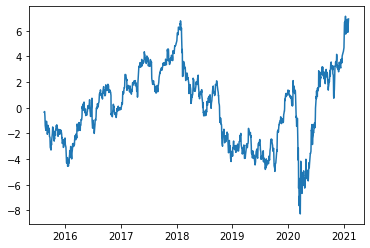

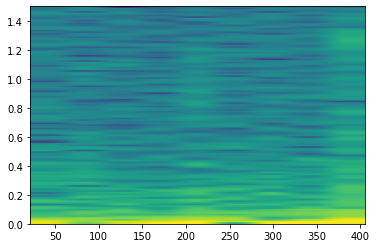

In [64]:
fft_output = np.fft.fft(stockdata_df['Diff'])
power = np.abs(fft_output)


plt.plot(x,stockdata_df['Diff'])
plt.show() 
plt.specgram(stockdata_df['Diff'],Fs=3,mode = 'psd',scale='dB')
plt.show() 
